In [1]:
import os
import sys

import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from pathlib import Patha
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn import metrics
from scipy.sparse import csr_matrix
import multiprocessing as mp
import numpy as np
from GraphCVAE import GraphCVAE,run


# Set environment variable for CUDA device
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
data_path = "/data/" 
data_name = '10.5e1s1' 
save_path = "/data/GraphCVAE/Results" #### save path

In [3]:
deepen = run(save_path = save_path,)
###### Read in other spatial data, or user can read in themselves. Including original expression
###### information and spatial location information, where the location information is saved in .obsm["spatial"]
adata = deepen._get_adata(platform="stereoSeq", data_path=data_path, data_name=data_name)

In [4]:
adata = deepen._get_augment(adata, spatial_type="KDTree", use_morphological=False)


Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0
Gene correlation calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|██████████ [ time left: 00:00 ]


Step 1: Augment molecule expression is Done!


In [5]:
from scipy.sparse import csr_matrix
augment_sparse = csr_matrix(adata.obsm['augment_gene_data'])
adata.X = augment_sparse+adata.X

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
os.environ['R_HOME'] = '/usr/lib/R'

In [7]:
adata_aug=adata

In [9]:
model = GraphCVAE(adata_aug, device=device,epochs=1200,n_top_genes=4000)

# train model
adata_aug = model.train()

2024-08-14 08:19:47.520534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 08:19:47.538056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 08:19:47.543204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 08:19:48.346886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Begin to train ST data...


100%|██████████| 1200/1200 [02:07<00:00,  9.40it/s]


Optimization finished for ST data!


In [11]:
adata_aug

AnnData object with n_obs × n_vars = 4672 × 25201
    obs: 'imagecol', 'imagerow'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'weights_matrix_all', 'adjacent_data', 'augment_gene_data', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [12]:
tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphCVAE.utils import clustering
n_clusters =16
if tool == 'mclust':
   clustering(adata_aug, n_clusters, method=tool)
elif tool in ['leiden', 'louvain']:
   clustering(adata_aug, n_clusters, method=tool, start=0.1, end=2.0, increment=0.01)
original_coords = adata_aug.obsm['spatial']


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


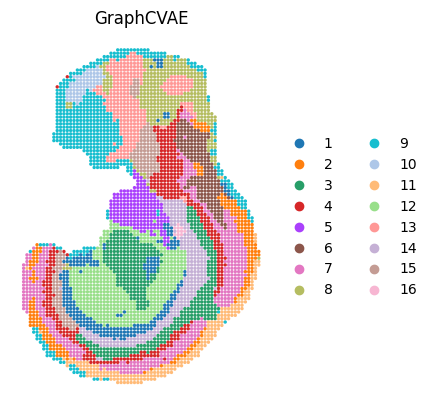

In [26]:
original_coords = adata_aug.obsm['spatial']

# Define a 180-degree rotation matrix (equivalent to flipping both x and y axes)
rotation_matrix = np.array([[-1, 0],
                            [0, -1]])

# Apply the rotation matrix
rotated_coords = np.dot(original_coords, rotation_matrix)

# Update the coordinates in the adata object
adata_aug.obsm['spatial'] = rotated_coords

# Plot the spatial graph after rotation
sc.pl.spatial(adata_aug, color='domain', frameon=False, spot_size=1, title='GraphCVAE')